In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torchvision.utils import save_image, make_grid

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [8]:
path = '/kaggle/input/dataset/lfw'

In [9]:
transform  = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True) ## Removed shuffle to check the output of three models for the same input


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [10]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


torch.Size([250, 250, 3])


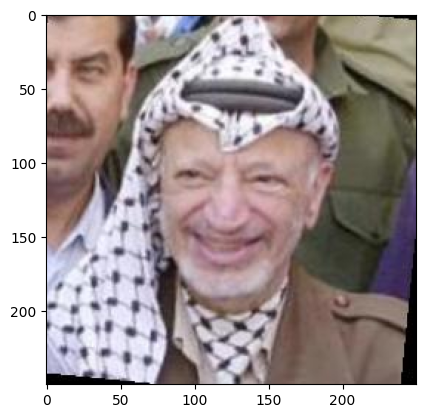

In [11]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [43]:

data = iter(dataloader)
image,target = next(data)
batch, channel, width, height = image.shape
print(x.shape)
print("Batch size :", batch)
print("Total channel :", channel)
print("Width of Image :", width)
print("Height of Image :", height)

print("Target :",target.shape)
print("Here batch size is 32, therefore target is a single integer value")



torch.Size([32, 3, 250, 250])
Batch size : 32
Total channel : 3
Width of Image : 250
Height of Image : 250
Target : torch.Size([32])
Here batch size is 32, therefore target is a single integer value


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [20]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
                                 nn.BatchNorm2d(8),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
                                 nn.BatchNorm2d(16), 
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),  
                                 nn.BatchNorm2d(32),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2) 
                                ) 
            

    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(16),
                             
                             nn.ConvTranspose2d(16,8, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(8),
                             
                             nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images
       

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [21]:
model = AE()

In [22]:
data = iter(dataloader)
image,target = next(data)

encoded_output = model.encoded_images(image)
print(encoded_output.shape)
decoded_output = model.decoded_images(encoded_output)

print(decoded_output.shape)
forward_complete = model.forward(image)
print(forward_complete.shape)

# Decoded Dimensions are same as Input Dimensions

torch.Size([32, 32, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [23]:
# Print model summary with parameters
print("Model Summary:")
for name, param in model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}, Shape: {param.shape}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Model Summary:
Layer: encoded_images.0.weight, Parameters: 216, Shape: torch.Size([8, 3, 3, 3])
Layer: encoded_images.0.bias, Parameters: 8, Shape: torch.Size([8])
Layer: encoded_images.1.weight, Parameters: 8, Shape: torch.Size([8])
Layer: encoded_images.1.bias, Parameters: 8, Shape: torch.Size([8])
Layer: encoded_images.4.weight, Parameters: 1152, Shape: torch.Size([16, 8, 3, 3])
Layer: encoded_images.4.bias, Parameters: 16, Shape: torch.Size([16])
Layer: encoded_images.5.weight, Parameters: 16, Shape: torch.Size([16])
Layer: encoded_images.5.bias, Parameters: 16, Shape: torch.Size([16])
Layer: encoded_images.8.weight, Parameters: 4608, Shape: torch.Size([32, 16, 3, 3])
Layer: encoded_images.8.bias, Parameters: 32, Shape: torch.Size([32])
Layer: encoded_images.9.weight, Parameters: 32, Shape: torch.Size([32])
Layer: encoded_images.9.bias, Parameters: 32, Shape: torch.Size([32])
Layer: decoded_images.0.weight, Parameters: 4608, Shape: torch.Size([32, 16, 3, 3])
Layer: decoded_images.0

## Loss Function 

--> In autoencoders, the Mean Squared Error (MSE) loss function is commonly used as the reconstruction loss. The goal of an autoencoder is to learn a compressed representation of the input data and then reconstruct it as closely as possible. The MSE loss measures the average squared difference between the input and the reconstructed output.

--> The MSE loss encourages the autoencoder to produce reconstructions that closely match the original input. It penalizes large differences between the input and reconstructed values, making it suitable for tasks where the goal is to minimize the pixel-wise reconstruction error.

--> Autoencoders aim to reduce the dimensionality of input data (Input) by mapping it to a lower-dimensional latent space (Z) through an encoding process. The primary objective is to capture salient features of the input data and subsequently reconstruct the original data from this compact representation (Z) through a decoding process (Input → Encoder → Z → Decoder → Output).



In [25]:
loss_function = nn.MSELoss()

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

--> If the loss function is not decreasing, I will change the architecture of my neural network, adjust the learning rate, preprocess the input images if requried.

In [26]:
epochs = 320
for epoch in range(epochs):
    total_loss = 0
    for x,y in dataloader:
        
        # ===================forward=====================
        decoded_images = model.forward(x)
        loss = loss_function(decoded_images, x)
        
        # ===================backward====================
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, total_loss))

epoch [1/320], loss:0.3106
epoch [2/320], loss:0.3156
epoch [3/320], loss:0.2906
epoch [4/320], loss:0.2823
epoch [5/320], loss:0.2579
epoch [6/320], loss:0.2461
epoch [7/320], loss:0.2454
epoch [8/320], loss:0.2296
epoch [9/320], loss:0.2166
epoch [10/320], loss:0.2180
epoch [11/320], loss:0.1915
epoch [12/320], loss:0.2081
epoch [13/320], loss:0.1928
epoch [14/320], loss:0.2067
epoch [15/320], loss:0.1625
epoch [16/320], loss:0.1642
epoch [17/320], loss:0.1601
epoch [18/320], loss:0.1454
epoch [19/320], loss:0.1547
epoch [20/320], loss:0.1394
epoch [21/320], loss:0.1453
epoch [22/320], loss:0.1399
epoch [23/320], loss:0.1259
epoch [24/320], loss:0.1238
epoch [25/320], loss:0.1450
epoch [26/320], loss:0.1411
epoch [27/320], loss:0.1302
epoch [28/320], loss:0.1174
epoch [29/320], loss:0.1312
epoch [30/320], loss:0.1351
epoch [31/320], loss:0.1281
epoch [32/320], loss:0.1094
epoch [33/320], loss:0.1042
epoch [34/320], loss:0.1127
epoch [35/320], loss:0.1097
epoch [36/320], loss:0.1142
e

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

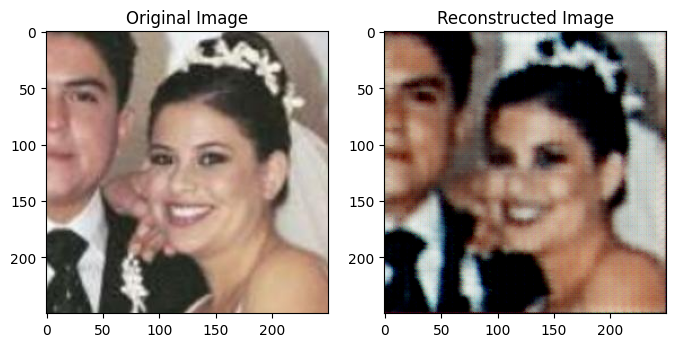

In [29]:
data = iter(dataloader)
image,target = next(data)
original_image = image[3]

# Forward pass through the model
with torch.no_grad():
    reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

plt.show()

## Trying another model.

--> I will be changing the Architecture of the neural network and increasing the epochs as well

In [30]:
class AE1(nn.Module):
    
    def __init__(self):
        super(AE1,self).__init__()  
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        
    def encoder(self):

            return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
                                 nn.BatchNorm2d(32),  
                                 nn.ReLU(True), 
                                 nn.MaxPool2d(2, stride=2), 
                                 
                                 nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
                                 nn.BatchNorm2d(64),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),  
                                 nn.BatchNorm2d(128),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2) 
                                ) 
            

    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),
                             
                             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(32),
                             
                             nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
        
    def forward(self,x):
        encoded_images = self.encoded_images(x)
        decoded_images = self.decoded_images(encoded_images)
        return decoded_images
       

In [31]:
model1 = AE1()

In [32]:
data = iter(dataloader)
image,target = next(data)
output1 = model1.encoded_images(image)
print(output1.shape)
decode1 = model1.decoded_images(output1)

print(decode1.shape)
forward_complete1 = model1.forward(image)
print(forward_complete1.shape)

torch.Size([32, 128, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


In [33]:
total_parameters1 = sum(params.numel() for params in model1.parameters())
print(total_parameters1)

187011


## Optimizer and loss function will be same

In [34]:
optim1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-5)
loss_function = nn.MSELoss()

In [35]:
epochs = 500
for epoch in range(epochs):
    total_loss = 0
    for x,y in dataloader:
        # ===================forward=====================
        decoded_images1 = model1.forward(x)
        loss = loss_function(decoded_images1, x)
        
        # ===================backward====================
        
        optim1.zero_grad()
        loss.backward()
        optim1.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, epochs, total_loss))

epoch [1/500], loss:0.4965
epoch [2/500], loss:0.3791
epoch [3/500], loss:0.3333
epoch [4/500], loss:0.2392
epoch [5/500], loss:0.1947
epoch [6/500], loss:0.2176
epoch [7/500], loss:0.1746
epoch [8/500], loss:0.1507
epoch [9/500], loss:0.1535
epoch [10/500], loss:0.1614
epoch [11/500], loss:0.1562
epoch [12/500], loss:0.1461
epoch [13/500], loss:0.1247
epoch [14/500], loss:0.1381
epoch [15/500], loss:0.1381
epoch [16/500], loss:0.1140
epoch [17/500], loss:0.1165
epoch [18/500], loss:0.1020
epoch [19/500], loss:0.1074
epoch [20/500], loss:0.1200
epoch [21/500], loss:0.1180
epoch [22/500], loss:0.1031
epoch [23/500], loss:0.1055
epoch [24/500], loss:0.0901
epoch [25/500], loss:0.1144
epoch [26/500], loss:0.0756
epoch [27/500], loss:0.0844
epoch [28/500], loss:0.0932
epoch [29/500], loss:0.0971
epoch [30/500], loss:0.0980
epoch [31/500], loss:0.0913
epoch [32/500], loss:0.0821
epoch [33/500], loss:0.0860
epoch [34/500], loss:0.1000
epoch [35/500], loss:0.0997
epoch [36/500], loss:0.0797
e

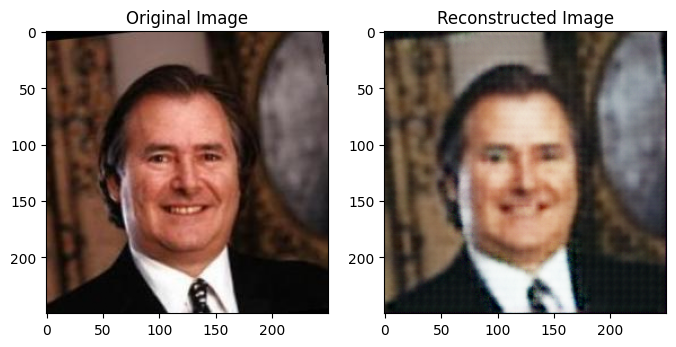

In [37]:
data = iter(dataloader)
image,target = next(data)
original_image = image[6]

# Forward pass through the model
with torch.no_grad():
    reconstructed_image = model1(original_image.unsqueeze(0))  # Add an extra dimension for batch size

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

plt.show()

## Why it's still not same
--> If there is inherent noise or variability in the input data, even a low reconstruction loss might not eliminate all discrepancies between the original and decoded images. The model may prioritize certain aspects of reconstruction over others. It's common for autoencoders to produce slightly imperfect reconstructions, and the goal is often to capture the most salient features rather than achieving pixel-perfect reproduction.

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

-->


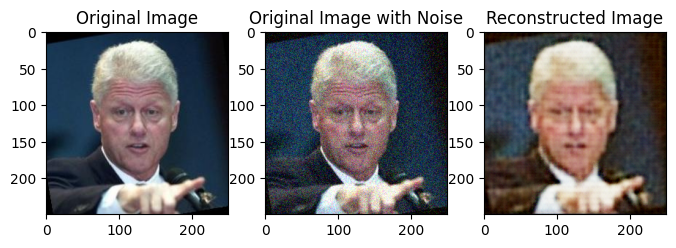

In [42]:
data = iter(dataloader)
image,target = next(data)
original_image = image[6]
noise = torch.randn_like(original_image) * 0.1  # You can adjust the scale of the noise
original_image_with_noise = original_image + noise
# Forward pass through the model
with torch.no_grad():
    reconstructed_image_with_noise = model1(original_image_with_noise.unsqueeze(0))  # Add an extra dimension for batch size

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
original_image_np_with_noise = original_image_with_noise.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image_with_noise.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(original_image_np_with_noise)
axes[1].set_title('Original Image with Noise')


axes[2].imshow(reconstructed_image_np)
axes[2].set_title('Reconstructed Image')

plt.show()

## What are affects of adding noise?

--> The model learns to focus on essential features while smoothing out less critical variations, improving its ability to generalize while adding noise to it

--> Noise encourages the autoencoder to capture only the most important features, leading to a condensed latent space that retains essential information.

-->As the model learns to reconstruct from noisy latent representations, it becomes adept at filtering out irrelevant details and focusing on the core features.